In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from matplotlib.pyplot import figure
import math

# Models
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, plot_confusion_matrix

# Bias

import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.sklearn.metrics import disparate_impact_ratio
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import StandardDataset


pd.options.mode.chained_assignment = None 
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.7f' % x)

In [103]:
df_original = pd.read_csv(r"C:\Users\bassa\Desktop\Natwest\Dataset\adult.csv")

In [104]:
# Rescale the elements of the column to a number
def rescale_elements(df, feature):
    x=df[feature].value_counts()
    item_type_mapping = {}
    item_list = x.index
    for i in range(0,len(item_list)):
        item_type_mapping[item_list[i]] = i
    df[feature]=df[feature].map(lambda x:item_type_mapping[x])
    return df

In [105]:
# rescale race (white = 0, black = 1) after dropping: Asian-Pac-Islander, Amer-Indian-Eskimo, Other
df = df_original[df_original['race'].isin(['White', 'Black'])]
df['race'][df['race'] == 'White'] = 0
df['race'][df['race'] == 'Black'] = 1

# rescale sex (sex : male = 0 , female = 1)
df['gender'][df['gender'] == 'Male'] = 0
df['gender'][df['gender'] == 'Female'] = 1

# rescale marital status (Married-civ-spouse = 0, Never-married = 1) after dropping 'others'
df['marital-status'][df['marital-status'].isin(['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'])] = 0
df['marital-status'][df['marital-status'].isin(['Never-married', 'Divorced', 'Separated', 'Widowed'])] = 1

# rescale income (>50K = 0, <=50K = 1)
df['income'][df['income'] == '>50K'] = 0
df['income'][df['income'] == '<=50K'] = 1

# rescale native-country (United-States = 0, any other country = 1)
df['native-country'][df['native-country'] == 'United-States'] = 0
df['native-country'][df['native-country'] != 0] = 1

# rescale education 
df = rescale_elements(df, 'education')

# rescale relationship
df = rescale_elements(df, 'relationship')

# rescale occupation
df = rescale_elements(df, 'occupation')

# rescale workclass
df = rescale_elements(df, 'workclass')

# Transform the object in integers and reset the index
df = df.apply(pd.to_numeric).reset_index(drop=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46447 entries, 0 to 46446
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   age              46447 non-null  int64
 1   workclass        46447 non-null  int64
 2   fnlwgt           46447 non-null  int64
 3   education        46447 non-null  int64
 4   educational-num  46447 non-null  int64
 5   marital-status   46447 non-null  int64
 6   occupation       46447 non-null  int64
 7   relationship     46447 non-null  int64
 8   race             46447 non-null  int64
 9   gender           46447 non-null  int64
 10  capital-gain     46447 non-null  int64
 11  capital-loss     46447 non-null  int64
 12  hours-per-week   46447 non-null  int64
 13  native-country   46447 non-null  int64
 14  income           46447 non-null  int64
dtypes: int64(15)
memory usage: 5.3 MB


## Metrics

#### Disparate Impact Ratio (DIR)

It compares the proportion of individuals that receive a positive output for two groups: an unprivileged group and a privileged group.
The aim is to have the metric close to one but as a industry standard a result above 80% acceptable.


$$\frac{P(Y=1│D=unpriviledged)}{P(Y=1│D=priviledged)} $$

#### Statistical parity

Evaluate the proportion of each segment of a protected class (gender). The probability of having a positive outcome should be equal.
The metric looks at the difference between the unprivileged and the privilege.

$$P(Y│D=unpriviledged) = P(Y│D=priviledged) $$

#### Equal opportunity 

States that each group should get the positive outcome at equal rates, assuming that people in this group qualify for it. It requires the positive outcome to be independent of the protected class A, conditional on Y being an actual positive.
Based on the confusion matrix, we require the True Positive Rate (TPR) to be the same for each segment of the protected class.

$$P(Y=1│D=unpriviledged, Y=y) = P(Y=1│D=priviledged,Y=y), y\in{0,1} $$


In [106]:
def fair_metrics(data, y_pred, target, protected_attribute_names) :
    dataset = StandardDataset(data, 
                          label_name=target, 
                          favorable_classes=[0], 
                          protected_attribute_names=protected_attribute_names, 
                          privileged_classes=[[0]])

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {f'disparate_impact_{protected_attribute_names[0]}': metric_pred.disparate_impact(),
              f'statistical_parity_difference_{protected_attribute_names[0]}': metric_pred.statistical_parity_difference(),
              f'equal_opportunity_difference_{protected_attribute_names[0]}': classified_metric.equal_opportunity_difference()}
        
    return result

## Mitigation

#### Disaparate impact remover



In [107]:
# sex (sex : male = 0 , female = 1) - income (>50K = 0, <=50K = 1)
def DIR(data, target_variable, protect_attriburte):
    binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
        favorable_label= 0,
        unfavorable_label= 1,
        df= data,
        label_names=[target_variable],
        protected_attribute_names=[protect_attriburte])
    di = DisparateImpactRemover(repair_level = 1.0)
    dataset_transf_train = di.fit_transform(binaryLabelDataset)
    transformed = dataset_transf_train.convert_to_dataframe()[0]
    x_trans = transformed.drop([target_variable], axis = 1)
    y = transformed[target_variable]
    return x_trans, y, transformed

## EDA

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


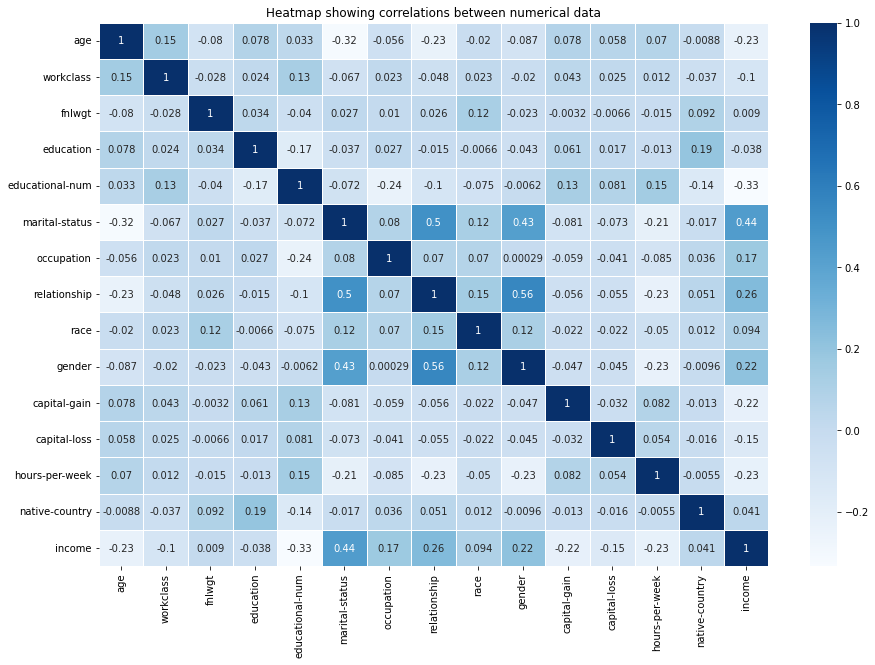

In [108]:
plt.figure(figsize=(15,10))  
sns.heatmap(df.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [109]:
fair_metrics(df, df['income'], 'income', ['gender'])

{'disparate_impact_gender': 0.35753759606703406,
 'statistical_parity_difference_gender': -0.19615422907428784,
 'equal_opportunity_difference_gender': 0.0}

In [110]:
def distribution_features_groups(df, sensitive_attribute):
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15), sharex=False, sharey=False)
    axes = axes.ravel()  # array to 1D
    columns = df.columns
    cols = columns[columns != sensitive_attribute]  # create a list of dataframe columns to use

    for col, ax in zip(cols, axes):
        data = df[[col, sensitive_attribute]]  # select the data
        sns.kdeplot(data=data, x=col, hue=sensitive_attribute, shade=True, ax=ax)
        ax.set(title=f'Distribution of Column: {col}', xlabel=None)
        
    fig.delaxes(axes[-1]) 
    fig.delaxes(axes[-2]) # delete the empty subplot
    fig.tight_layout()
    return plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


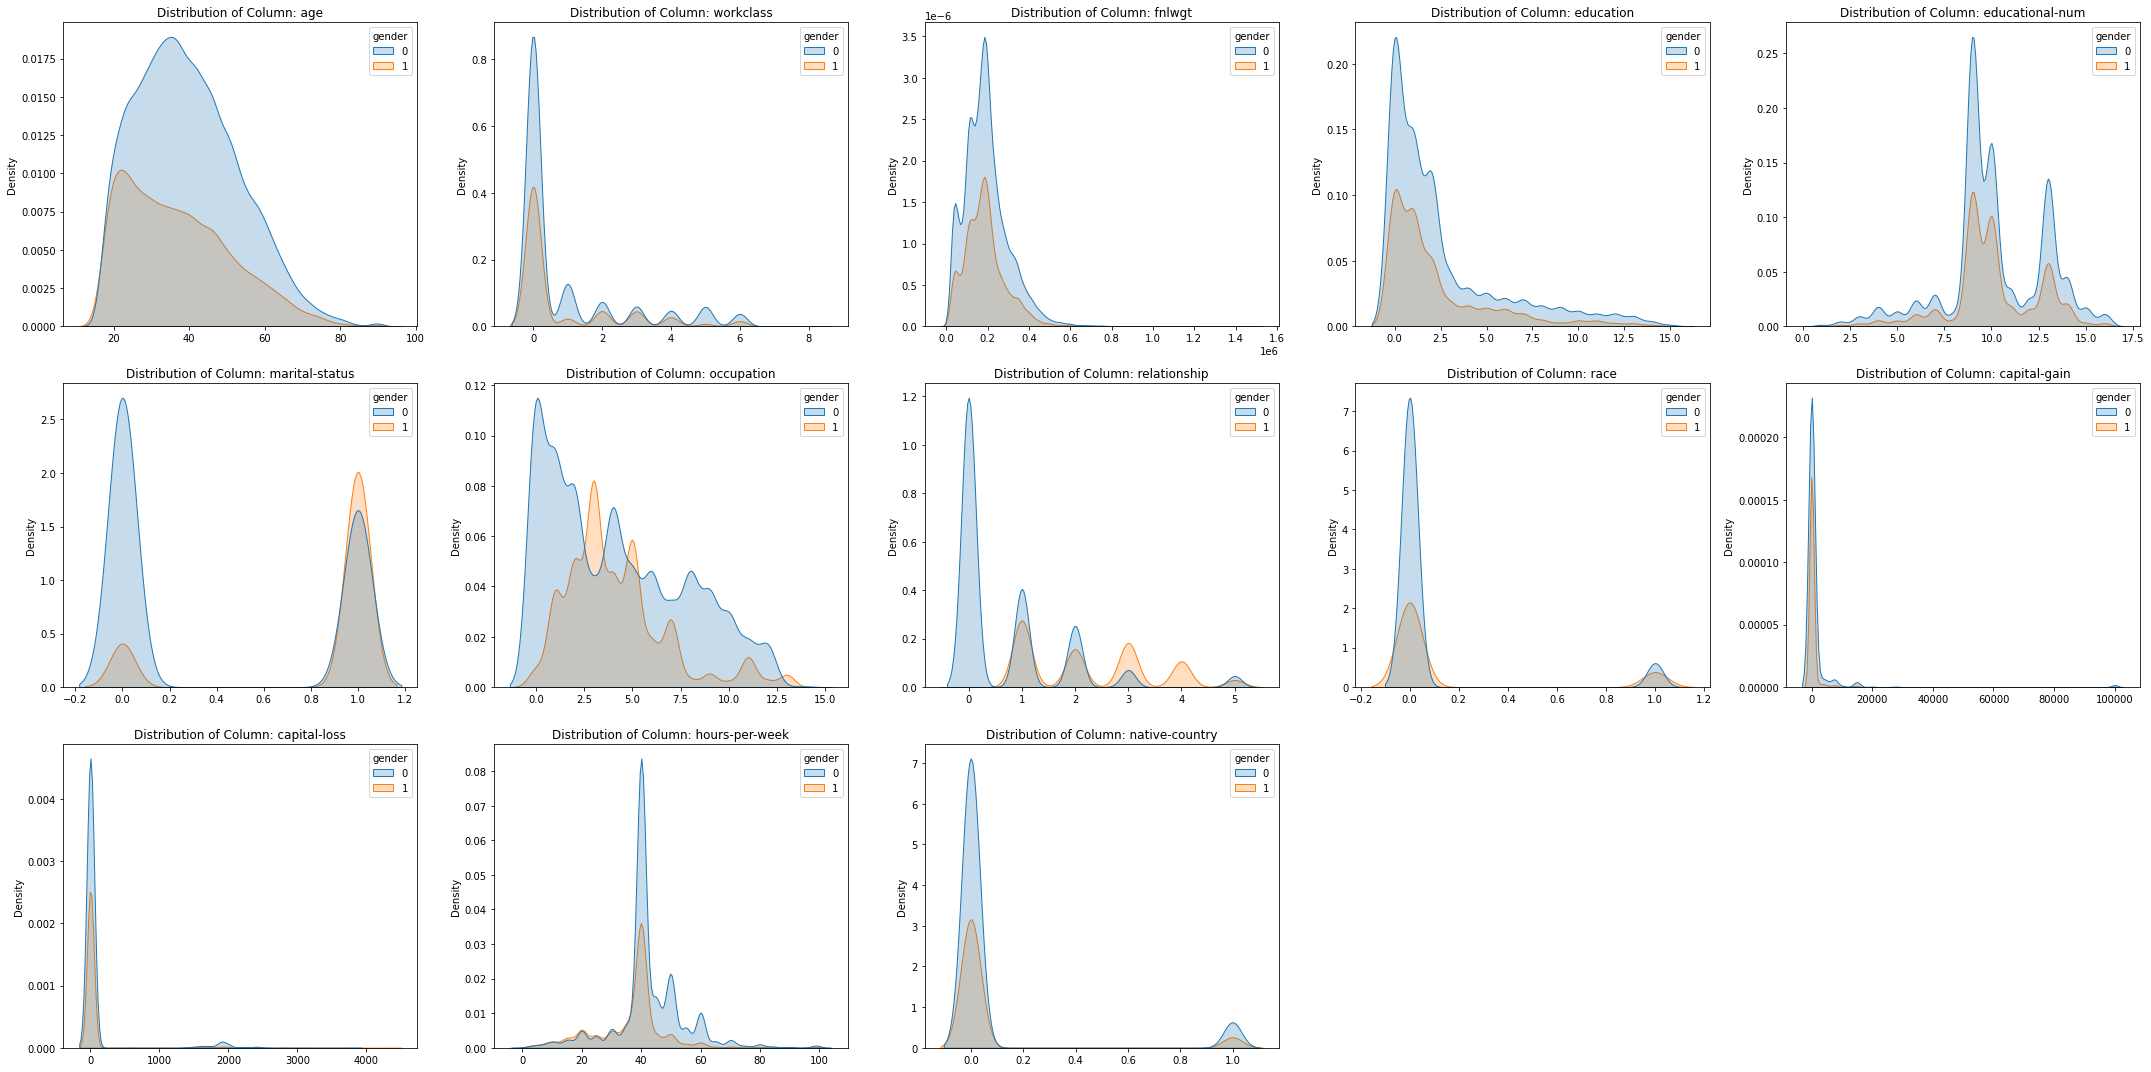

In [111]:
distribution_features_groups(df, 'gender')

## Beta coeff experiment 

In [112]:
#Function to transform the continuous prediciton to a binary classification 

def binomial_classification(y_predition):
    
    '''Transform the continual prediction to a binary classification
        1 = Default, 0 = Non Default 
        input = the continuos prediction from the model
        output = pandas data frame with the binary classification on the colum prediction '''

    y_predict = pd.DataFrame(y_predition, columns=['prediction'])
    y_predict['prediction'][y_predict['prediction'] >= 0.5] = 1
    y_predict['prediction'][y_predict['prediction'] < 0.5] = 0
    return y_predict

In [113]:
# Split the normal dataset
x = df.drop(['income'], axis = 1)
y = df['income'] 
default_seed = 1
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=default_seed)

In [114]:
# Split the DIR dataset 
x_trans, y_trans, df_trans = DIR(df, 'income', 'race')
default_seed = 1
x_train_trans, x_test_trans, y_train_trans, y_test_trans = train_test_split(x_trans, y_trans, test_size=0.4, random_state=default_seed)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


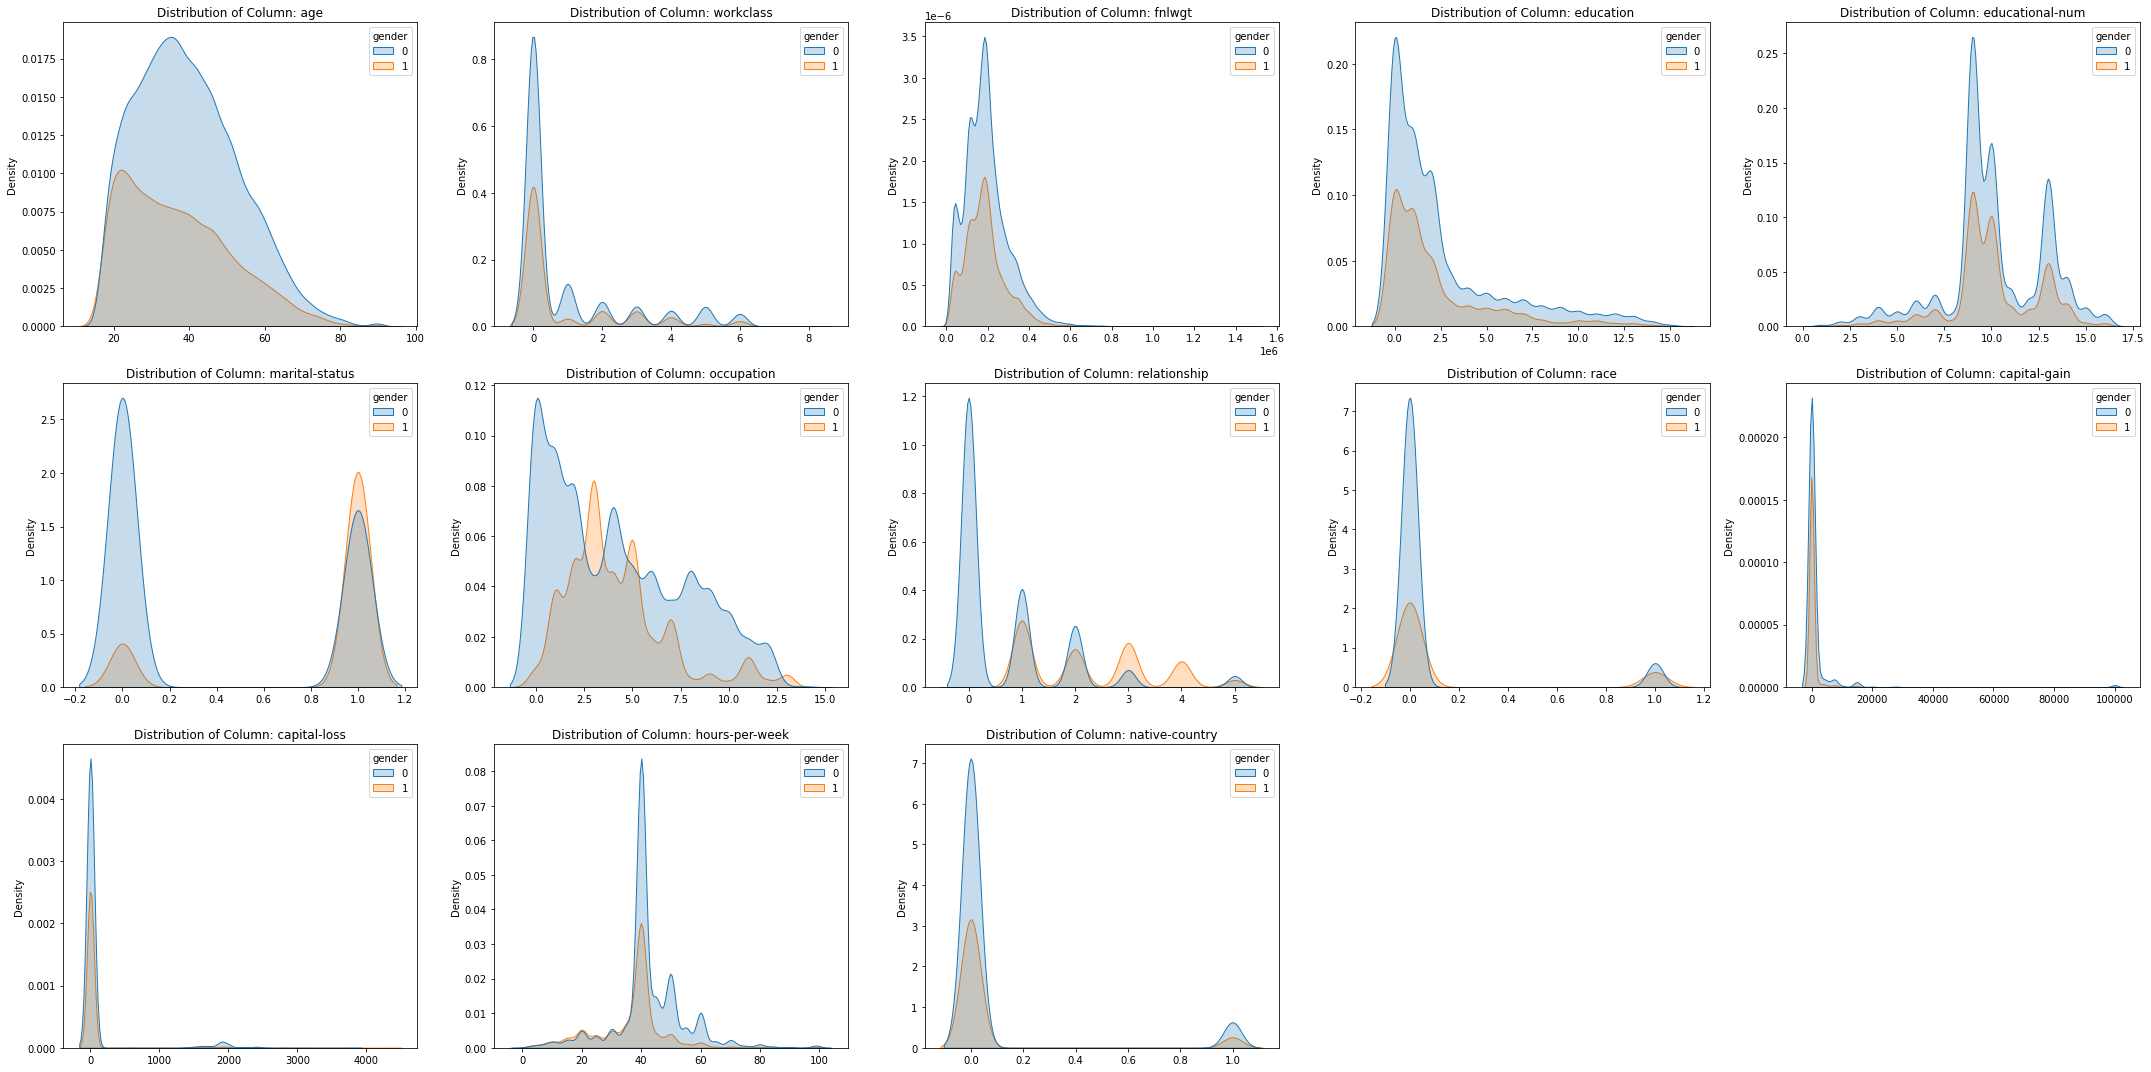

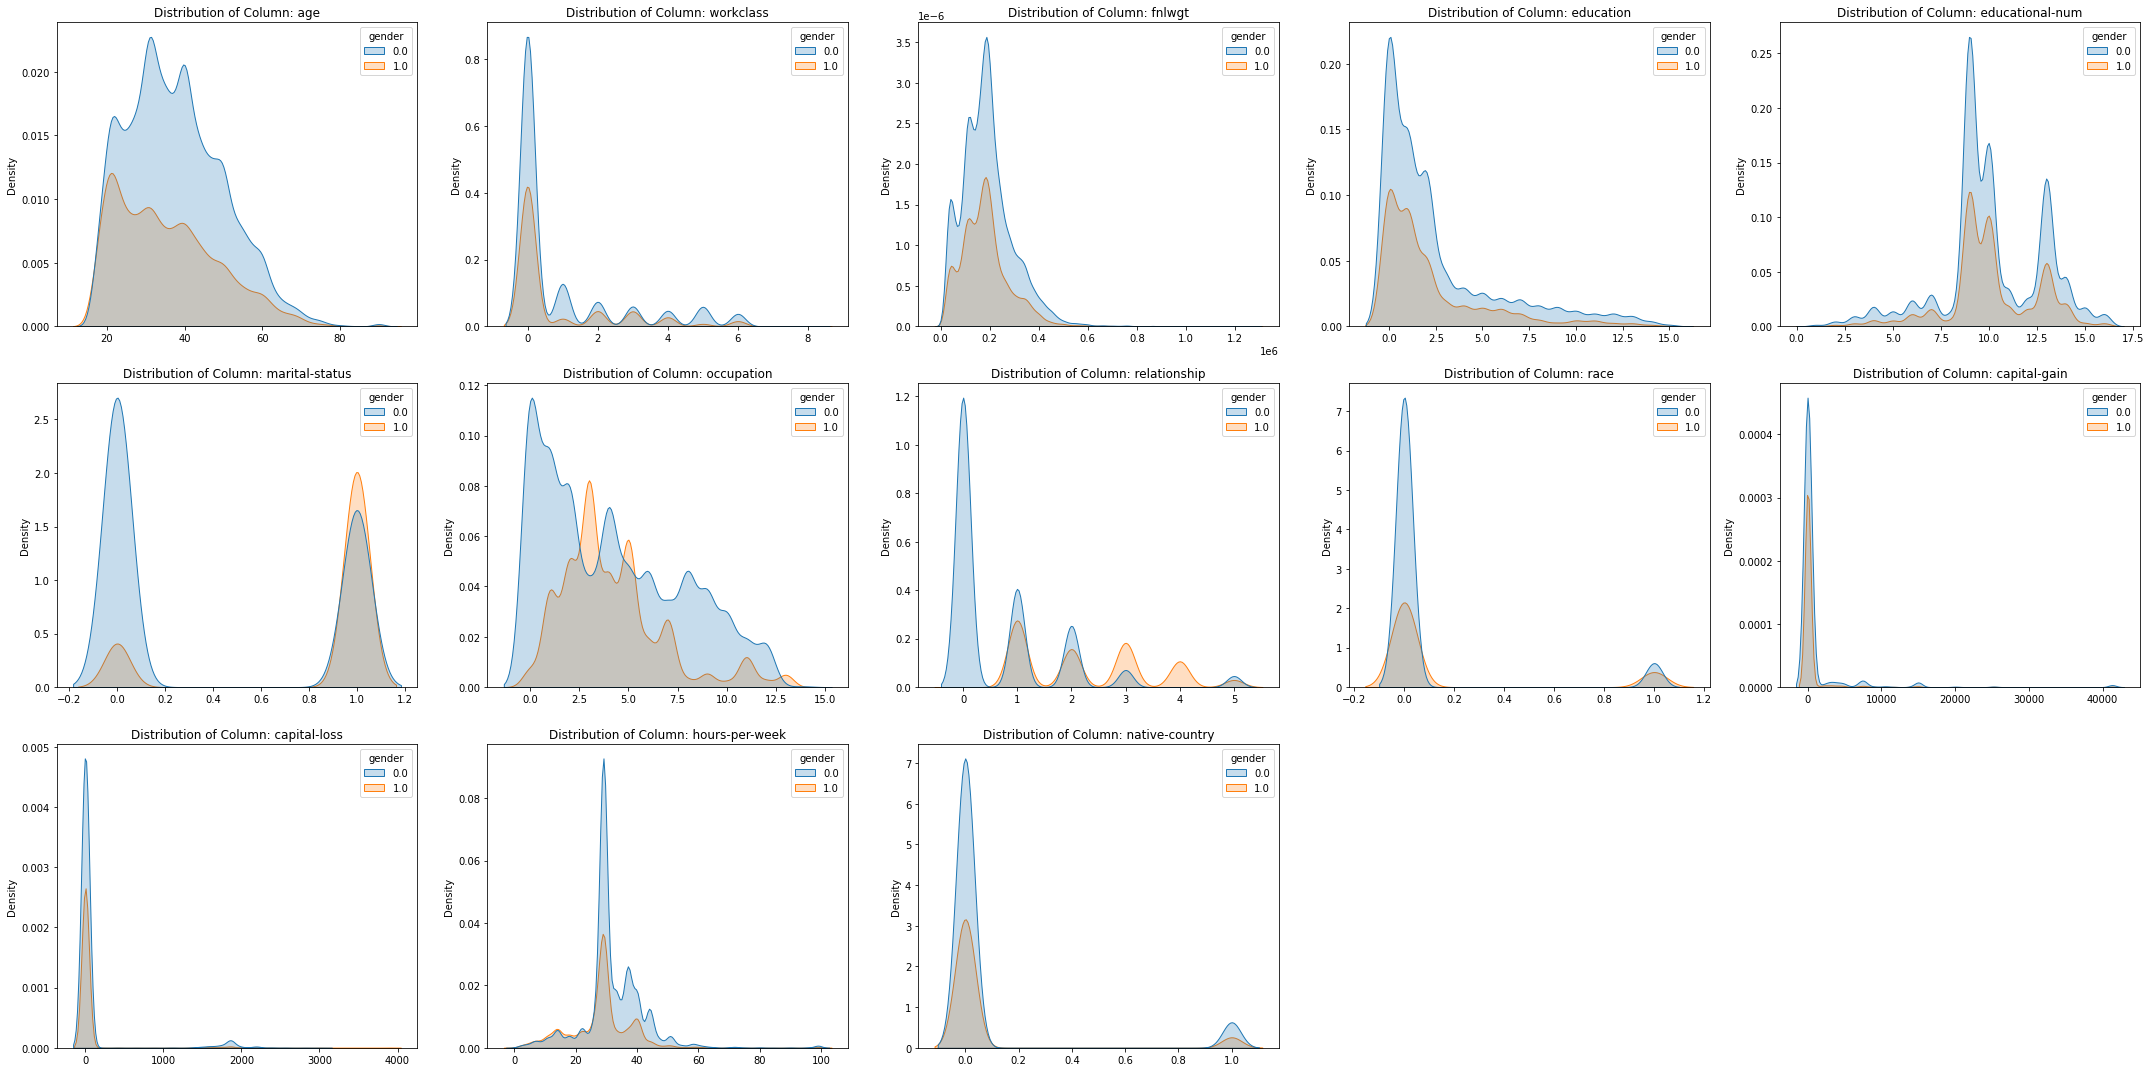

In [115]:
distribution_features_groups(df, 'gender')
distribution_features_groups(df_trans, 'gender')

In [116]:
linear_model = sm.OLS(y_train, x_train,).fit()
linear_model_trans = sm.OLS(y_train_trans, x_train_trans).fit()

In [117]:
#Buils a data frame for comparison
comparison_df = pd.DataFrame(data = {
    'Non-processed': linear_model.params,
    'Pre-prosessed': linear_model_trans.params
})

#Calculate the change in beta coeff and metrics
comparison_df['change %'] = ((comparison_df['Pre-prosessed'] - comparison_df['Non-processed']) / comparison_df['Non-processed']) * 100
comparison_df

,Non-processed,Pre-prosessed,change %
age,0.0041192,0.0049134,19.2793907
workclass,-0.0115269,-0.0112750,-2.1851819
fnlwgt,0.0000004,0.0000004,3.4581185
education,0.0017878,0.0024819,38.8283493
educational-num,0.0010572,0.0035584,236.5890128
marital-status,0.3998857,0.3923427,-1.8862911
occupation,0.0262563,0.0255125,-2.8329522
relationship,0.0202102,0.0203797,0.8388822
race,0.0261227,-0.0133798,-151.2189794
gender,0.0388489,0.0326529,-15.9488856


In [118]:
# Prediction on the test dataset and trasformation to a bionomial classification 1 = income, 0 = non income
y_predict = binomial_classification(linear_model.predict(x_test))
y_predict_trans = binomial_classification(linear_model_trans.predict(x_test_trans))

#Claculate the disparate impact metric for preprocessed and non-processed experiment
metric_df = x_test.copy()
metric_df.insert(0, 'income', y_test)
metric_df_trans = x_test_trans.copy()
metric_df_trans.insert(0, 'income', y_test_trans)

lr_metric = fair_metrics(metric_df, y_predict.values.ravel(), 'income', ['gender'])
lr_trans_metric = fair_metrics(metric_df_trans, y_predict_trans.values.ravel(), 'income', ['gender'])
metrics_comparison = pd.DataFrame([lr_metric,lr_trans_metric], index=['linear model','linear model trans']).T
metrics_comparison['change %'] = ((metrics_comparison['linear model trans'] - metrics_comparison['linear model']) / metrics_comparison['linear model']) * 100

In [119]:
metrics_comparison

,linear model,linear model trans,change %
disparate_impact_gender,0.1153136,0.1275646,10.6240534
statistical_parity_difference_gender,-0.2692369,-0.2455656,-8.7920079
equal_opportunity_difference_gender,-0.3250328,-0.2733772,-15.8924234


In [120]:
metric_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18579 entries, 30085 to 46156
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   income           18579 non-null  int64
 1   age              18579 non-null  int64
 2   workclass        18579 non-null  int64
 3   fnlwgt           18579 non-null  int64
 4   education        18579 non-null  int64
 5   educational-num  18579 non-null  int64
 6   marital-status   18579 non-null  int64
 7   occupation       18579 non-null  int64
 8   relationship     18579 non-null  int64
 9   race             18579 non-null  int64
 10  gender           18579 non-null  int64
 11  capital-gain     18579 non-null  int64
 12  capital-loss     18579 non-null  int64
 13  hours-per-week   18579 non-null  int64
 14  native-country   18579 non-null  int64
dtypes: int64(15)
memory usage: 2.3 MB


In [121]:
y_predict.values.ravel()

array([1., 1., 0., ..., 1., 1., 1.])

In [122]:
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                 income   R-squared (uncentered):                   0.803
Model:                            OLS   Adj. R-squared (uncentered):              0.803
Method:                 Least Squares   F-statistic:                              8091.
Date:                Thu, 07 Jul 2022   Prob (F-statistic):                        0.00
Time:                        15:25:21   Log-Likelihood:                         -13138.
No. Observations:               27868   AIC:                                  2.630e+04
Df Residuals:                   27854   BIC:                                  2.642e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [123]:
print(linear_model_trans.summary())

                                 OLS Regression Results                                
Dep. Variable:                 income   R-squared (uncentered):                   0.809
Model:                            OLS   Adj. R-squared (uncentered):              0.809
Method:                 Least Squares   F-statistic:                              8411.
Date:                Thu, 07 Jul 2022   Prob (F-statistic):                        0.00
Time:                        15:25:21   Log-Likelihood:                         -12703.
No. Observations:               27868   AIC:                                  2.543e+04
Df Residuals:                   27854   BIC:                                  2.555e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

## Random Forrest experiment

In [124]:
# Split the DIR dataset and normalise it 
df_features = df.iloc[:,:-1]
scaler = StandardScaler()
x_data = scaler.fit_transform(df_features)
default_seed = 1
x_train, x_test, y_train, y_test = train_test_split(x_data, y, test_size=0.4, random_state=default_seed)


In [125]:
# Split the DIR dataset and normalise it 
x_trans, y_trans, df_trans = DIR(df, 'income', 'race')
scaler = StandardScaler()
x_trans = scaler.fit_transform(x_trans)
default_seed = 1
x_train_trans, x_test_trans, y_train_trans, y_test_trans = train_test_split(x_trans, y_trans, test_size=0.4, random_state=default_seed)

In [126]:
rf = RandomForestClassifier().fit(x_train, y_train)
y_preds_rf = rf.predict(x_test)
print(classification_report(y_test, y_preds_rf))

              precision    recall  f1-score   support

           0       0.74      0.62      0.68      4531
           1       0.88      0.93      0.91     14048

    accuracy                           0.86     18579
   macro avg       0.81      0.78      0.79     18579
weighted avg       0.85      0.86      0.85     18579



In [127]:
rf_trans = RandomForestClassifier().fit(x_train_trans, y_train_trans)
y_preds_rf_trans = rf_trans.predict(x_test_trans)
print(classification_report(y_test_trans, y_preds_rf_trans))

              precision    recall  f1-score   support

         0.0       0.74      0.63      0.68      4531
         1.0       0.88      0.93      0.91     14048

    accuracy                           0.85     18579
   macro avg       0.81      0.78      0.79     18579
weighted avg       0.85      0.85      0.85     18579



In [128]:
pd.DataFrame(x_test).set_axis(df_features.columns, axis = 1)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,-1.2888698,-0.5482378,1.0370934,-0.4511219,-0.0257982,0.9440559,0.5620532,0.5857673,-0.3349378,1.4243676,-0.1452843,-0.2176345,-0.0364481,-0.2935552
1,-0.0532464,-0.5482378,0.8269046,-0.4511219,-0.0257982,0.9440559,-1.2691322,-0.1574549,-0.3349378,-0.7020660,-0.1452843,-0.2176345,0.2859950,-0.2935552
2,0.3101722,-0.5482378,1.1194987,-0.1356178,1.1504946,-1.0592593,-1.2691322,-0.9006770,-0.3349378,-0.7020660,-0.1452843,-0.2176345,-0.0364481,-0.2935552
3,-0.7074000,-0.5482378,0.5631000,0.4953904,0.3662994,-1.0592593,0.5620532,-0.9006770,-0.3349378,-0.7020660,-0.1452843,-0.2176345,-0.0364481,-0.2935552
4,0.7462746,0.0682941,0.0758112,-0.4511219,-0.0257982,-1.0592593,-0.0483419,-0.9006770,-0.3349378,-0.7020660,-0.1452843,-0.2176345,0.7696597,-0.2935552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18574,-1.1435023,-0.5482378,0.6035336,-0.7666260,-0.4178958,0.9440559,-1.2691322,0.5857673,-0.3349378,-0.7020660,-0.1452843,-0.2176345,-0.0364481,-0.2935552
18575,-1.4342372,0.0682941,-1.3598891,-0.4511219,-0.0257982,0.9440559,-1.2691322,-0.1574549,-0.3349378,1.4243676,-0.1452843,-0.2176345,-2.0517177,-0.2935552
18576,0.1648048,0.0682941,-1.5540648,-0.7666260,-0.4178958,0.9440559,-1.2691322,-0.1574549,-0.3349378,-0.7020660,-0.1452843,-0.2176345,-0.0364481,-0.2935552
18577,-1.5069209,-0.5482378,-0.6363301,0.8108945,-1.2020910,0.9440559,-0.0483419,0.5857673,-0.3349378,1.4243676,-0.1452843,-0.2176345,0.6890489,-0.2935552


In [129]:
#Claculate the disparate impact metric for preprocessed and non-processed experiment
metric_df = pd.DataFrame(x_test).set_axis(df_features.columns, axis = 1)
metric_df['gender'][metric_df['gender'] < 0] = 0
metric_df['gender'][metric_df['gender'] > 0] = 1
metric_df.insert(0, 'income', y_test.reset_index(drop=True))
metric_df_trans = pd.DataFrame(x_test_trans).set_axis(df_features.columns, axis = 1)
metric_df_trans['gender'][metric_df_trans['gender'] < 0] = 0
metric_df_trans['gender'][metric_df_trans['gender'] > 0] = 1
metric_df_trans.insert(0, 'income', y_test_trans.reset_index(drop=True))

lr_metric = fair_metrics(metric_df, pd.DataFrame(y_preds_rf).values.ravel(), 'income', ['gender'])
lr_trans_metric = fair_metrics(metric_df_trans, y_preds_rf_trans, 'income', ['gender'])
metrics_comparison = pd.DataFrame([lr_metric,lr_trans_metric], index=['rf','rf trans']).T
metrics_comparison['change %'] = ((metrics_comparison['rf trans'] - metrics_comparison['rf']) / metrics_comparison['rf']) * 100

In [130]:
metrics_comparison

,rf,rf trans,change %
disparate_impact_gender,0.3272273,0.3167974,-3.1873531
statistical_parity_difference_gender,-0.1763700,-0.1828986,3.7016414
equal_opportunity_difference_gender,-0.0631750,-0.0800761,26.7528083
